# CSSM502 Final Project

## Dataset Preparations

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sevvalckc","key":"f2edb988e52c9e7a4e9cf59ae8aefa12"}'}

In [2]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!ls -lah /root/.kaggle
!kaggle --version


total 16K
drwxr-xr-x 2 root root 4.0K Jan 21 20:12 .
drwx------ 1 root root 4.0K Jan 21 20:12 ..
-rw------- 1 root root   65 Jan 21 20:12 kaggle.json
Kaggle API 1.7.4.5


In [3]:
!kaggle datasets list -s "reddit comments" | head -n 25


ref                                                           title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
sherinclaudia/sarcastic-comments-on-reddit                    Sarcastic Comments - REDDIT                        110984528  2019-01-30 14:41:53.703000           3816        129  0.7647059        
kaggle/reddit-comments-may-2015                               May 2015 Reddit Comments                         21429083286  2019-06-04 10:06:44.657000          11934        302  0.64705884       
danofer/sarcasm                                               Sarcasm on Reddit                                  226798960  2018-05-27 08:19:04.850000          15882        263  1.0              
gpreda/reddit-vaccin

In [4]:
!rm -rf data_en
!mkdir -p data_en
!kaggle datasets download -d smagnan/1-million-reddit-comments-from-40-subreddits -p data_en --unzip
!find data_en -type f | head -n 50


Dataset URL: https://www.kaggle.com/datasets/smagnan/1-million-reddit-comments-from-40-subreddits
License(s): CC0-1.0
  0% 0.00/71.2M [00:00<?, ?B/s]
100% 71.2M/71.2M [00:00<00:00, 970MB/s]
data_en/kaggle_RC_2019-05.csv


In [5]:
import glob, pandas as pd

en_files = glob.glob("data_en/**/*.csv", recursive=True)
print("CSV files:", en_files)

df_en_raw = pd.read_csv(en_files[0])
print("df_en_raw shape:", df_en_raw.shape)
print("columns:", list(df_en_raw.columns)[:30])
df_en_raw.head(2)


CSV files: ['data_en/kaggle_RC_2019-05.csv']
df_en_raw shape: (1000000, 4)
columns: ['subreddit', 'body', 'controversiality', 'score']


,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19


In [6]:
text_candidates = [c for c in df_en_raw.columns if c.lower() in ["body","text","comment","comments","content"]]
sub_candidates  = [c for c in df_en_raw.columns if "sub" in c.lower()]  # subreddit / subreddit_id vs.

print("text candidates:", text_candidates)
print("sub candidates:", sub_candidates)

TEXT_COL = text_candidates[0]
SUB_COL  = sub_candidates[0] if sub_candidates else None

df_en_raw[TEXT_COL] = df_en_raw[TEXT_COL].fillna("").astype(str)

en_kw = [
    "work","job","boss","manager","overtime","burnout","stress","toxic",
    "salary","wage","pay","harassment","anxiety","depressed","quit",
    "resign","resignation","fired","laid off","workload","exhaust"
]
pattern = "|".join([k.replace(" ", "\\s+") for k in en_kw])

df_en_pool = df_en_raw[df_en_raw[TEXT_COL].str.lower().str.contains(pattern, na=False)].copy()
df_en_pool["text"] = df_en_pool[TEXT_COL].str.strip()


df_en_pool = df_en_pool[df_en_pool["text"].str.len() >= 30]


if SUB_COL:
    workish = ["antiwork","jobs","careeradvice","work","burnout","depression","anxiety"]
    df_en_pool = df_en_pool[
        df_en_pool[SUB_COL].astype(str).str.lower().isin(workish) |
        df_en_pool[TEXT_COL].str.lower().str.contains(pattern, na=False)
    ].copy()

print("EN pool size:", df_en_pool.shape)


if len(df_en_pool) >= 10000:
    df_en_10k = df_en_pool.sample(10000, random_state=42)
else:

    broad_kw = ["tired","exhausted","hate my job","money","rent","bills","career","unemployed","overworked"]
    broad_pat = "|".join([k.replace(" ", "\\s+") for k in broad_kw])
    df_en_pool2 = df_en_raw[df_en_raw[TEXT_COL].str.lower().str.contains(broad_pat, na=False)].copy()
    df_en_pool2["text"] = df_en_pool2[TEXT_COL].fillna("").astype(str).str.strip()
    df_en_pool2 = df_en_pool2[df_en_pool2["text"].str.len() >= 30]
    df_en_10k = pd.concat([df_en_pool, df_en_pool2], ignore_index=True).drop_duplicates(subset=["text"]).head(10000)

print("EN final (raw) shape:", df_en_10k.shape)
df_en_10k[["text"]].head(3)


text candidates: ['body']
sub candidates: ['subreddit']
EN pool size: (64246, 5)
EN final (raw) shape: (10000, 5)


,text
486181,"So, I'm going to cite Agents of Shield here. W..."
110470,"Except it is going to happen to us all, we wil..."
920841,You as an engineer don't have to answer to sha...


## Preprocessing

In [7]:
import re
import pandas as pd

def clean_text_basic(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()

    # remove deleted/removed placeholders
    if s.lower() in ["[deleted]", "[removed]"]:
        return ""

    # remove URLs
    s = re.sub(r"http\S+|www\.\S+", " ", s)

    # remove excessive markdown quotes (lines starting with >)
    s = re.sub(r"(?m)^\s*>\s?.*$", " ", s)

    # normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

df_en_pool_clean = df_en_pool.copy()
df_en_pool_clean["text_clean"] = df_en_pool_clean["text"].apply(clean_text_basic)

df_en_pool_clean = df_en_pool_clean[df_en_pool_clean["text_clean"].str.len() >= 50].copy()

df_en_pool_clean = df_en_pool_clean.drop_duplicates(subset=["text_clean"])

print("EN pool before:", df_en_pool.shape)
print("EN pool after clean:", df_en_pool_clean.shape)

df_en_10k_clean = df_en_pool_clean.sample(min(10000, len(df_en_pool_clean)), random_state=42).copy()

df_en_10k_clean = df_en_10k_clean.rename(columns={"text_clean": "text"})
df_en_10k_clean = df_en_10k_clean[["text"] + [c for c in df_en_10k_clean.columns if c != "text"]]

print("EN final clean 10k:", df_en_10k_clean.shape)
df_en_10k_clean[["text"]].head(3)


EN pool before: (64246, 5)
EN pool after clean: (59895, 6)
EN final clean 10k: (10000, 6)


,text,text
804473,I don't see it presented as a justification - ...,I don't see it presented as a justification - ...
972149,You look like a mother fucker who would blast ...,You look like a mother fucker who would blast ...
279094,The trailer made the writing sound pretty bad ...,The trailer made the writing sound pretty bad ...


In [8]:
df_en_10k_clean.to_csv("EN_clean_10k.csv", index=False)
print("Saved EN_clean_10k.csv rows:", len(df_en_10k_clean))

Saved EN_clean_10k.csv rows: 10000


In [9]:
df_final = df_en_10k_clean.copy()

print("Final EN shape:", df_final.shape)
df_final.head(3)

Final EN shape: (10000, 6)


,text,text,subreddit,body,controversiality,score
804473,I don't see it presented as a justification - ...,I don't see it presented as a justification - ...,videos,I don't see it presented as a justification - ...,0,-2
972149,You look like a mother fucker who would blast ...,You look like a mother fucker who would blast ...,RoastMe,You look like a mother fucker who would blast ...,0,-1
279094,The trailer made the writing sound pretty bad ...,The trailer made the writing sound pretty bad ...,unpopularopinion,The trailer made the writing sound pretty bad ...,0,1


In [10]:
df_final = df_final.copy()

df_final["text"] = df_final["text"].astype(str)

df_final = df_final.drop(columns=["body"], errors="ignore")

print(df_final.shape)
df_final.head(2)


(10000, 5)


,text,text,subreddit,controversiality,score
804473,I don't see it presented as a justification - ...,I don't see it presented as a justification - ...,videos,0,-2
972149,You look like a mother fucker who would blast ...,You look like a mother fucker who would blast ...,RoastMe,0,-1


In [11]:
df_final.columns

Index(['text', 'text', 'subreddit', 'controversiality', 'score'], dtype='object')

In [12]:
txt = df_final.loc[:, "text"]
df_final = df_final.drop(columns=["text"])

df_final["text"] = txt.iloc[:, 0].astype(str)

print(df_final.columns)
print(type(df_final["text"]))
df_final.head(3)


Index(['subreddit', 'controversiality', 'score', 'text'], dtype='object')
<class 'pandas.core.series.Series'>


,subreddit,controversiality,score,text
804473,videos,0,-2,I don't see it presented as a justification - ...
972149,RoastMe,0,-1,You look like a mother fucker who would blast ...
279094,unpopularopinion,0,1,The trailer made the writing sound pretty bad ...


In [13]:
en_kw = [
    "work","job","boss","manager","office","career","salary","wage",
    "rent","bills","money","economy","inflation",
    "burnout","stress","tired","exhausted","overwork","mental health",
    "unemployment","laid off","pay","raise","promotion"
]
pattern_en = "|".join(en_kw)

coverage = df_final["text"].str.lower().str.contains(pattern_en, na=False).mean()
coverage


np.float64(0.8649)

In [14]:
noise_kw = ["movie","film","actor","episode","season","game","match","goal","team","product","amazon","delivery"]
noise_pattern = "|".join(noise_kw)

noise_ratio = df_final["text"].str.lower().str.contains(noise_pattern, na=False).mean()
noise_ratio


np.float64(0.1974)

## Text Embedding

In [15]:
!pip -q install sentence-transformers


In [16]:
from sentence_transformers import SentenceTransformer
import numpy as np


In [17]:
# Pre-trained sentence embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
texts = df_final["text"].tolist()

embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True
)

print("embeddings.shape:", embeddings.shape)


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

embeddings.shape: (10000, 384)


## DIMENSIONALITY REDUCTION (UMAP)

In [19]:
!pip -q install umap-learn


In [20]:
import umap
import matplotlib.pyplot as plt


In [21]:
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.05,
    metric="cosine",
    random_state=42
)


In [22]:
umap_2d = umap_model.fit_transform(embeddings)

print(umap_2d.shape)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(10000, 2)


In [23]:
df_final["x"] = umap_2d[:, 0]
df_final["y"] = umap_2d[:, 1]

df_final[["x","y"]].head()



,x,y
804473,1.932641,4.766036
972149,0.539205,2.079546
279094,4.558591,1.817360
140030,0.215675,5.911231
52875,0.837071,5.932986


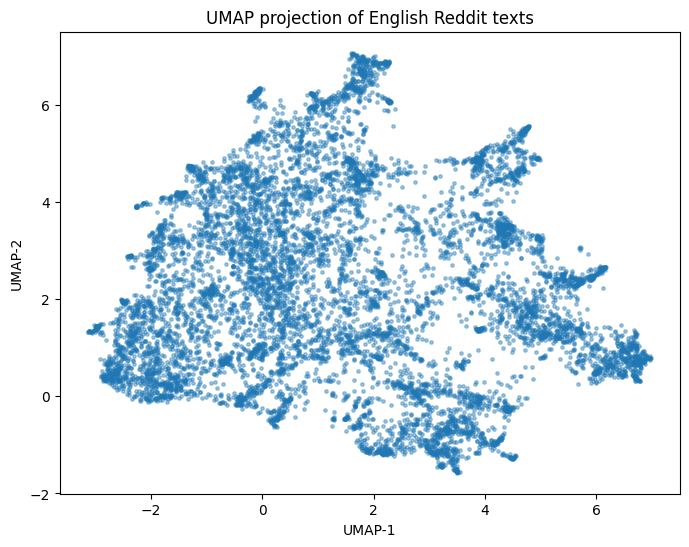

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(df_final["x"], df_final["y"], s=6, alpha=0.4)
plt.title("UMAP projection of English Reddit texts")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


## Clustering

In [25]:
from sklearn.cluster import KMeans


In [26]:
k = 8

kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init="auto"
)

clusters = kmeans.fit_predict(embeddings)

df_final["cluster"] = clusters

df_final["cluster"].value_counts()


,count
cluster,
2,1631
4,1397
0,1361
3,1313
5,1302
6,1247
7,1139
1,610


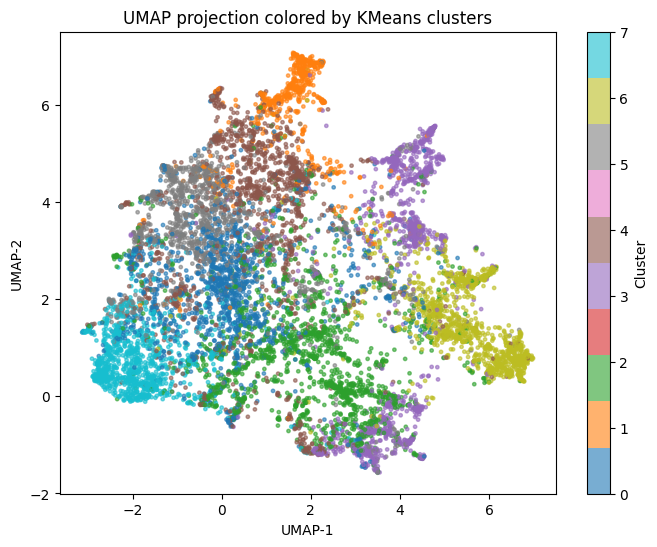

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_final["x"],
    df_final["y"],
    c=df_final["cluster"],
    cmap="tab10",
    s=6,
    alpha=0.6
)
plt.title("UMAP projection colored by KMeans clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster")
plt.show()


In [28]:
import numpy as np

centers = kmeans.cluster_centers_
centers = centers / np.linalg.norm(centers, axis=1, keepdims=True)


In [29]:
def get_representative_texts(cluster_id, n=5):
    idx = np.where(df_final["cluster"] == cluster_id)[0]
    sims = embeddings[idx] @ centers[cluster_id]
    top_idx = idx[np.argsort(-sims)[:n]]
    return df_final.iloc[top_idx][["text", "subreddit", "score"]]

# Örnek: cluster 0
get_representative_texts(0, n=5)


,text,subreddit,score
241464,"Soooo true... it’s all bright and shiny, “yeah...",funny,5
882783,This sounds like so many jobs I’ve had. Shitty...,FortNiteBR,1
819765,Thats not a good mindset to have. Next thing y...,Showerthoughts,0
658059,This is a stupid and asshole-ish attitude. If ...,movies,3
563037,That is the reality. But as someone who was in...,movies,1


In [30]:
for c in sorted(df_final["cluster"].unique()):
    print(f"\n=== CLUSTER {c} ===")
    display(get_representative_texts(c, n=5))



=== CLUSTER 0 ===


,text,subreddit,score
241464,"Soooo true... it’s all bright and shiny, “yeah...",funny,5
882783,This sounds like so many jobs I’ve had. Shitty...,FortNiteBR,1
819765,Thats not a good mindset to have. Next thing y...,Showerthoughts,0
658059,This is a stupid and asshole-ish attitude. If ...,movies,3
563037,That is the reality. But as someone who was in...,movies,1



=== CLUSTER 1 ===


,text,subreddit,score
82196,Barr needs to fucking resign now...\n\nCorrupt...,politics,243
254895,What do you know....\n\nWho would have thought...,politics,36
550478,He has to maintain PERFECT credibility in orde...,worldnews,1
52386,"He never got that opportunity, Mueller works u...",politics,6
359576,The fact that Mueller wrote a letter at all ab...,politics,40



=== CLUSTER 2 ===


,text,subreddit,score
258416,I just got all the heads in 20 mins 100% explo...,MortalKombat,11
400127,i promise you that it will work but it is brok...,MortalKombat,2
717466,Found it after all you fine gentlemen did the ...,FortNiteBR,1
773683,"Tbh this isnt working either, I hope I dont ha...",MortalKombat,1
867229,"It is super usefull and it worked for à while,...",FortNiteBR,1



=== CLUSTER 3 ===


,text,subreddit,score
337310,"I like both of those guys, but have you played...",leagueoflegends,5
298319,Do people actually think the ‘damaged goods’ t...,SquaredCircle,1
211730,Man what a tight rope Meltzer is trying to wal...,SquaredCircle,2
788663,It's been a combination of a few things for me...,SquaredCircle,4
554970,You've hit the nail on the head. Workrate does...,SquaredCircle,2



=== CLUSTER 4 ===


,text,subreddit,score
996538,You just keep living up to your user name with...,trashy,2
556089,So instead of trying to work with our local an...,news,5
914325,&gt;Get out of here with this gatekeeping bull...,ChapoTrapHouse,7
753759,That the problem is increasing because we have...,pics,2
879651,completely. not to mention that this whole com...,pics,2



=== CLUSTER 5 ===


,text,subreddit,score
935830,And then you slash their pay because clearly t...,todayilearned,51
575108,Lol as if any megarich scumbag pays their hous...,ChapoTrapHouse,22
819167,"Same, like what’s honestly so difference betwe...",Showerthoughts,-1
236068,I have a theory that the amount you have to pa...,gameofthrones,14
152708,"That's funny, when i was in high school it was...",trashy,1



=== CLUSTER 6 ===


,text,subreddit,score
178894,My jaw literally dropped when that moment came...,asoiaf,3
447399,"I agree, but I still think the show could've d...",asoiaf,2
463126,There are a lot of clearly valid criticisms of...,asoiaf,1
65983,I feel like I’m repeating myself because every...,gameofthrones,3
264110,"Um, ok. Answer me this... how can you ever exp...",asoiaf,1



=== CLUSTER 7 ===


,text,subreddit,score
706328,Maybe I’m being unnecessarily harsh here but i...,relationship_advice,3
774724,There’s a lot of jumping to the weight loss me...,relationship_advice,1
886372,Please make an exit plan for this relationship...,relationship_advice,1
137332,NTA. I feel like this is less about her being...,AmItheAsshole,2
160895,^^^^AUTOMOD ***The following is a copy of the...,AmItheAsshole,1


## Focused Analysis: Work-Related Discourse

In [31]:
WORK_CLUSTERS = [0, 4, 5]

df_work = df_final[df_final["cluster"].isin(WORK_CLUSTERS)].copy()

print("Work-related subset shape:", df_work.shape)
df_work["cluster"].value_counts()


Work-related subset shape: (4060, 7)


,count
cluster,
4,1397
0,1361
5,1302


In [32]:
coverage_work = df_work["text"].str.lower().str.contains(pattern_en, na=False).mean()
noise_work = df_work["text"].str.lower().str.contains(noise_pattern, na=False).mean()

coverage_work, noise_work


(np.float64(0.9110837438423646), np.float64(0.09507389162561576))

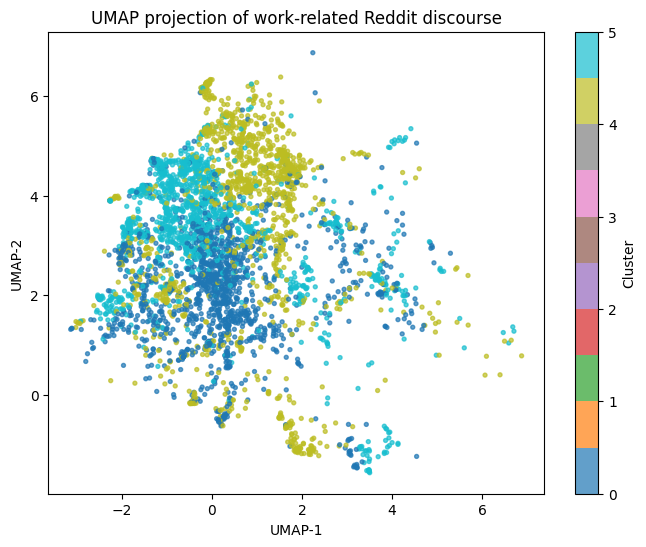

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_work["x"],
    df_work["y"],
    c=df_work["cluster"],
    cmap="tab10",
    s=8,
    alpha=0.7
)
plt.title("UMAP projection of work-related Reddit discourse")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster")
plt.show()


In [34]:
import pandas as pd

summary = {
    "EN_pool_raw": [df_en_raw.shape[0]],
    "EN_pool_filtered": [df_en_pool.shape[0]],
    "EN_pool_clean": [df_en_pool_clean.shape[0]],
    "EN_sampled_for_embedding": [df_final.shape[0]],  # 10,000
    "Coverage_keyword_rate": [float(coverage)],
    "Noise_keyword_rate": [float(noise_ratio)],
    "KMeans_k": [k],
    "Work_clusters": [str(WORK_CLUSTERS)],
    "Work_subset_size": [df_work.shape[0]],
    "Work_coverage_rate": [float(coverage_work)],
    "Work_noise_rate": [float(noise_work)],
}

df_summary = pd.DataFrame(summary)
df_summary


,EN_pool_raw,EN_pool_filtered,EN_pool_clean,EN_sampled_for_embedding,Coverage_keyword_rate,Noise_keyword_rate,KMeans_k,Work_clusters,Work_subset_size,Work_coverage_rate,Work_noise_rate
0,1000000,64246,59895,10000,0.8649,0.1974,8,"[0, 4, 5]",4060,0.911084,0.095074


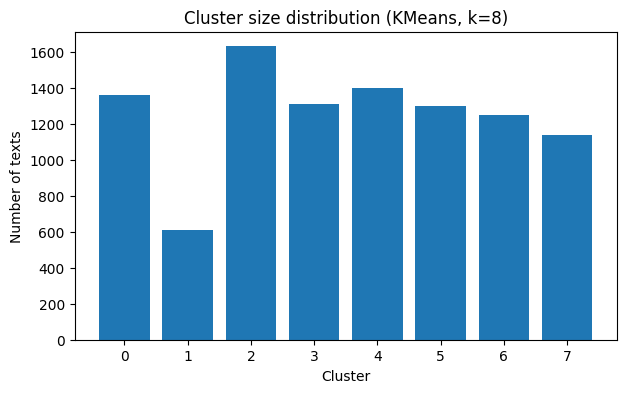

,count
cluster,
0,1361
1,610
2,1631
3,1313
4,1397
5,1302
6,1247
7,1139


In [35]:
import matplotlib.pyplot as plt

cluster_counts = df_final["cluster"].value_counts().sort_index()

plt.figure(figsize=(7,4))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.title("Cluster size distribution (KMeans, k=8)")
plt.xlabel("Cluster")
plt.ylabel("Number of texts")
plt.show()

cluster_counts


In [36]:
rows = []
for c in range(k):
    reps = get_representative_texts(c, n=10).copy()
    reps["cluster"] = c
    rows.append(reps)

df_reps = pd.concat(rows, ignore_index=True)
df_reps.to_csv("cluster_representatives_top10.csv", index=False)
print("Saved: cluster_representatives_top10.csv", df_reps.shape)


Saved: cluster_representatives_top10.csv (80, 4)


In [37]:
df_work_out = df_work[["text","subreddit","score","cluster","x","y"]].copy()
df_work_out.to_csv("EN_work_subset_3330.csv", index=False)
print("Saved: EN_work_subset_3330.csv", df_work_out.shape)


Saved: EN_work_subset_3330.csv (4060, 6)


In [38]:
import numpy as np

work_terms = ["work","job","boss","salary","wage","pay","rent","bills","burnout","stress","overtime","fired","laid off"]
pattern_work = "|".join([t.replace(" ", "\\s+") for t in work_terms])

cluster_diag = (
    df_final.assign(has_work=df_final["text"].str.lower().str.contains(pattern_work, na=False))
           .groupby("cluster")["has_work"]
           .mean()
           .sort_values(ascending=False)
)

cluster_diag


,has_work
cluster,
5,0.977727
0,0.943424
7,0.862160
6,0.850842
1,0.842623
2,0.830166
4,0.810308
3,0.779132
